# Ocean data handling

In this notebook we show how ocean data is handled.

In [1]:
# NBVAL_IGNORE_OUTPUT
import traceback
from os.path import join
    
import numpy as np
import iris
import iris.quickplot as qplt
import matplotlib
import matplotlib.pyplot as plt
from openscm.scmdataframe import ScmDataFrame

from netcdf_scm.iris_cube_wrappers import CMIP6OutputCube

<IPython.core.display.Javascript object>

In [2]:
# make all logs apper
import logging
root_logger = logging.getLogger()
root_logger.addHandler(logging.StreamHandler())

In [3]:
plt.style.use('bmh') 
%matplotlib inline

In [4]:
DATA_PATH_TEST = join("..", "tests", "test-data")
DATA_PATH_TEST_CMIP6_OUTPUT_ROOT = join(DATA_PATH_TEST, "cmip6output")

## Test data

For this notebook's test data we use CMIP6Output from NCAR's CESM2 model.

### 2D data

Some ocean data is 2D. Here we use surface downward heat flux in sea water.

Firstly we use data which has been regridded by the modelling group.

In [5]:
hfds_file = join(
    DATA_PATH_TEST,
    "cmip6output",
    "CMIP6",
    "CMIP",
    "NCAR",
    "CESM2",
    "historical",
    "r7i1p1f1",
    "Omon",
    "hfds",
    "gr",
    "v20190311",
    "hfds_Omon_CESM2_historical_r7i1p1f1_gr_195701-195703.nc"
)

We also examine how iris handles data which is provided on the native model grid.

In [6]:
hfds_file_gn = hfds_file.replace("gr", "gn")

### 3D data

Some ocean data is 3D. NetCDF-SCM currently supports crunching this to iris cubes but will not convert those cubes to SCM timeseries. 

In [7]:
thetao_file = join(
    DATA_PATH_TEST,
    "cmip6output",
    "CMIP6",
    "CMIP",
    "NCAR",
    "CESM2",
    "historical",
    "r10i1p1f1",
    "Omon",
    "thetao",
    "gn",
    "v20190313",
    "thetao_Omon_CESM2_historical_r10i1p1f1_gn_195310-195312.nc"
)

## 2D data handling

In [8]:
hfds_cube = CMIP6OutputCube()
hfds_cube.load_data_from_path(hfds_file)

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working


In [9]:
print(hfds_cube.cube)

surface_downward_heat_flux_in_sea_water / (W m-2) (time: 3; latitude: 180; longitude: 360)
     Dimension coordinates:
          time                                         x            -               -
          latitude                                     -            x               -
          longitude                                    -            -               x
     Cell Measures:
          cell_area                                    -            x               x
     Attributes:
          CDI: Climate Data Interface version 1.8.2 (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.8.2 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.7 CMIP-6.2
          activity_id: CMIP
          branch_method: standard
          branch_time_in_child: 674885.0
          branch_time_in_parent: 273750.0
          case_id: 21
          cesm_casename: b.e21.BHIST.f09_g17.CMIP6-historical.007
          comment: Model data on the 1x1 grid includes values in all c

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working


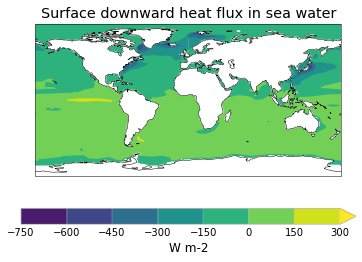

In [10]:
# NBVAL_IGNORE_OUTPUT
time_mean = hfds_cube.cube.collapsed('time', iris.analysis.MEAN)
qplt.contourf(
    time_mean, 
    extend='max',
)
plt.gca().coastlines();

Iris' handling of data on the native model grid is mostly workable, but not yet perfect.

In [11]:
hfds_cube_gn = CMIP6OutputCube()
hfds_cube_gn.load_data_from_path(hfds_file_gn)

print(hfds_cube_gn.cube)

surface_downward_heat_flux_in_sea_water / (W m-2) (time: 3; -- : 384; -- : 320)
     Dimension coordinates:
          time                                         x       -         -
     Auxiliary coordinates:
          latitude                                     -       x         x
          longitude                                    -       x         x
     Cell Measures:
          cell_area                                    -       x         x
     Attributes:
          CDI: Climate Data Interface version 1.8.2 (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.8.2 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.7 CMIP-6.2
          activity_id: CMIP
          branch_method: standard
          branch_time_in_child: 674885.0
          branch_time_in_parent: 273750.0
          case_id: 21
          cesm_casename: b.e21.BHIST.f09_g17.CMIP6-historical.007
          comment: This is the net flux of heat entering the liquid water column through its...
 

As we can see, iris doesn't plot data on these native model grids well (unlike the regridded data which it handles without problems).

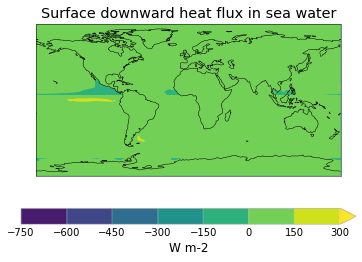

In [12]:
# NBVAL_IGNORE_OUTPUT
time_mean = hfds_cube_gn.cube.collapsed('time', iris.analysis.MEAN)
qplt.contourf(
    time_mean, 
    extend='max',
)
plt.gca().coastlines();

## Getting SCM Timeseries

We cut down to SCM timeseries in the standard way.

Not calculating land fractions as all required cubes are not available
Performing lazy conversion to datetime for calendar: 365_day. This may cause subtle errors in operations that depend on the length of time between dates
cannot be safely cast to variable data type
Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'latitude'.
Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'longitude'.
Not calculating land fractions as all required cubes are not available
Performing lazy conversion to datetime for calendar: 365_day. This may cause subtle errors in operations that depend on the length of time between dates


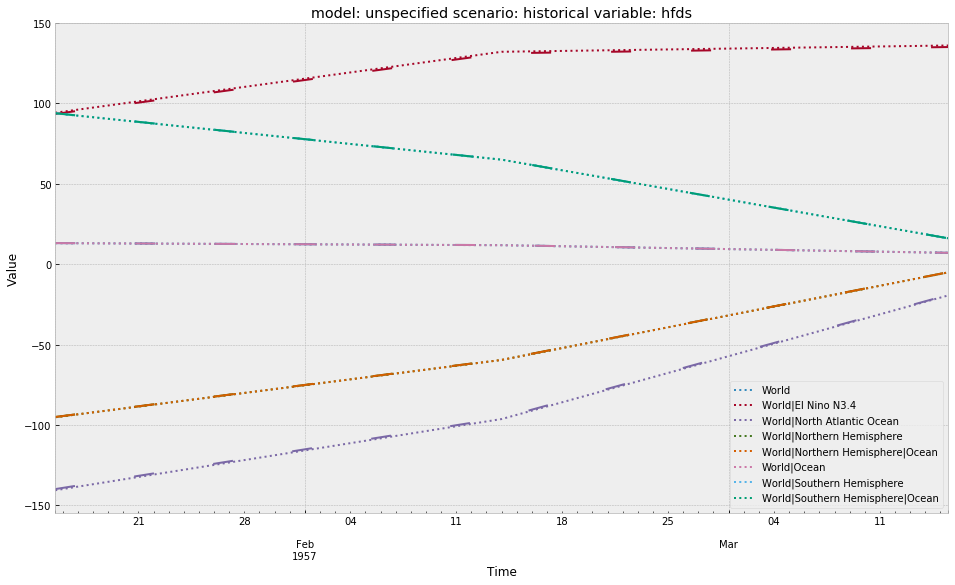

In [13]:
regions_to_get = [
    "World",
    "World|Northern Hemisphere",
    "World|Northern Hemisphere|Ocean",
    "World|Ocean",
    "World|Southern Hemisphere",
    "World|Southern Hemisphere|Ocean",
    "World|North Atlantic Ocean",
    "World|El Nino N3.4",
]
hfds_ts = hfds_cube.get_scm_timeseries(regions=regions_to_get)
hfds_gn_ts = hfds_cube_gn.get_scm_timeseries(regions=regions_to_get)

ax = hfds_ts.line_plot(color="region", linestyle=":", figsize=(16, 9))
hfds_gn_ts.line_plot(color="region", linestyle="--", dashes=(10, 30), ax=ax);

Comparing the results of collapsing the native grid and the regridded data reveals a small difference (approx 1%), in particular in the small El Nino N3.4 region.

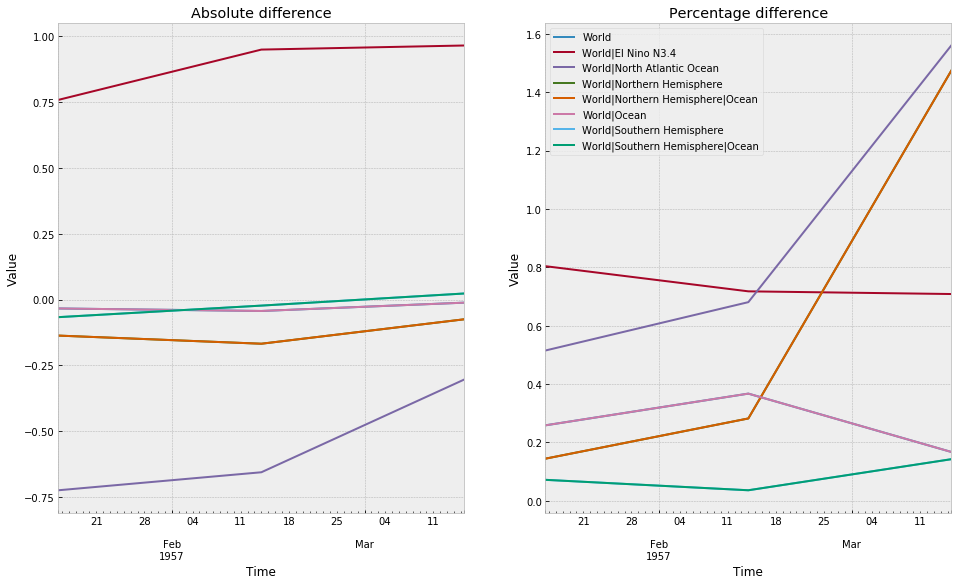

In [14]:
ax1, ax2 = plt.figure(figsize=(16, 9)).subplots(nrows=1, ncols=2)

ScmDataFrame(
    hfds_ts.timeseries() 
    - hfds_gn_ts.timeseries()
).line_plot(color="region", ax=ax1, legend=False)
ax1.set_title("Absolute difference")

ScmDataFrame(
    (
        (hfds_ts.timeseries() - hfds_gn_ts.timeseries()) 
        / hfds_ts.timeseries()
    ).abs() * 100
).line_plot(color="region", ax=ax2)
ax2.set_title("Percentage difference");

## 3D Data Handling

In [15]:
thetao_cube = CMIP6OutputCube()
thetao_cube.load_data_from_path(thetao_file)

Missing CF-netCDF measure variable 'volcello', referenced by netCDF variable 'thetao'


In [16]:
print(thetao_cube.cube)

sea_water_potential_temperature / (degC) (time: 3; generic: 60; -- : 384; -- : 320)
     Dimension coordinates:
          time                                x           -        -         -
          generic                             -           x        -         -
     Auxiliary coordinates:
          latitude                            -           -        x         x
          longitude                           -           -        x         x
     Cell Measures:
          cell_area                           -           -        x         x
     Attributes:
          CDI: Climate Data Interface version 1.8.2 (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.8.2 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.7 CMIP-6.2
          activity_id: CMIP
          branch_method: standard
          branch_time_in_child: 674885.0
          branch_time_in_parent: 306600.0
          case_id: 24
          cesm_casename: b.e21.BHIST.f09_g17.CMIP6-historical.01

If we take a time mean of a cube with 3D spatial data, we end up with a 3D cube, which cannot be plotted on a contour map.

In [17]:
# NBVAL_IGNORE_OUTPUT
time_mean = thetao_cube.cube.collapsed('time', iris.analysis.MEAN)
try:
    qplt.contourf(
        time_mean, 
        extend='max',
    )
except ValueError as e:
    traceback.print_exc(limit=0, chain=False)

Traceback (most recent call last):
ValueError: Cube must be 2-dimensional. Got 3 dimensions.


If we take e.g. a depth mean too, then we can plot (although as this data is on the model's native grid iris doesn't do a great job of plotting it).

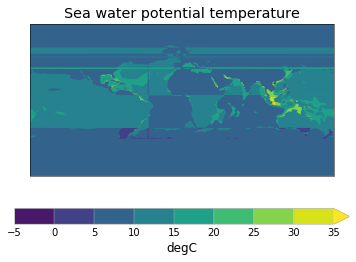

In [18]:
# NBVAL_IGNORE_OUTPUT
# the depth co-ordinate is labelled as 'generic' for some reason
time_depth_mean = time_mean.collapsed('generic', iris.analysis.MEAN)
qplt.contourf(
    time_depth_mean, 
    extend='max',
);

We can crunch into SCM timeseries cubes.

In [19]:
thetao_ts_cubes = thetao_cube.get_scm_timeseries_cubes(regions=regions_to_get)

cannot be safely cast to variable data type
Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'latitude'.
Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'longitude'.
Not calculating land fractions as all required cubes are not available


These cubes now have dimensions of time and depth (labelled as 'generic' here). Hence we can plot them.

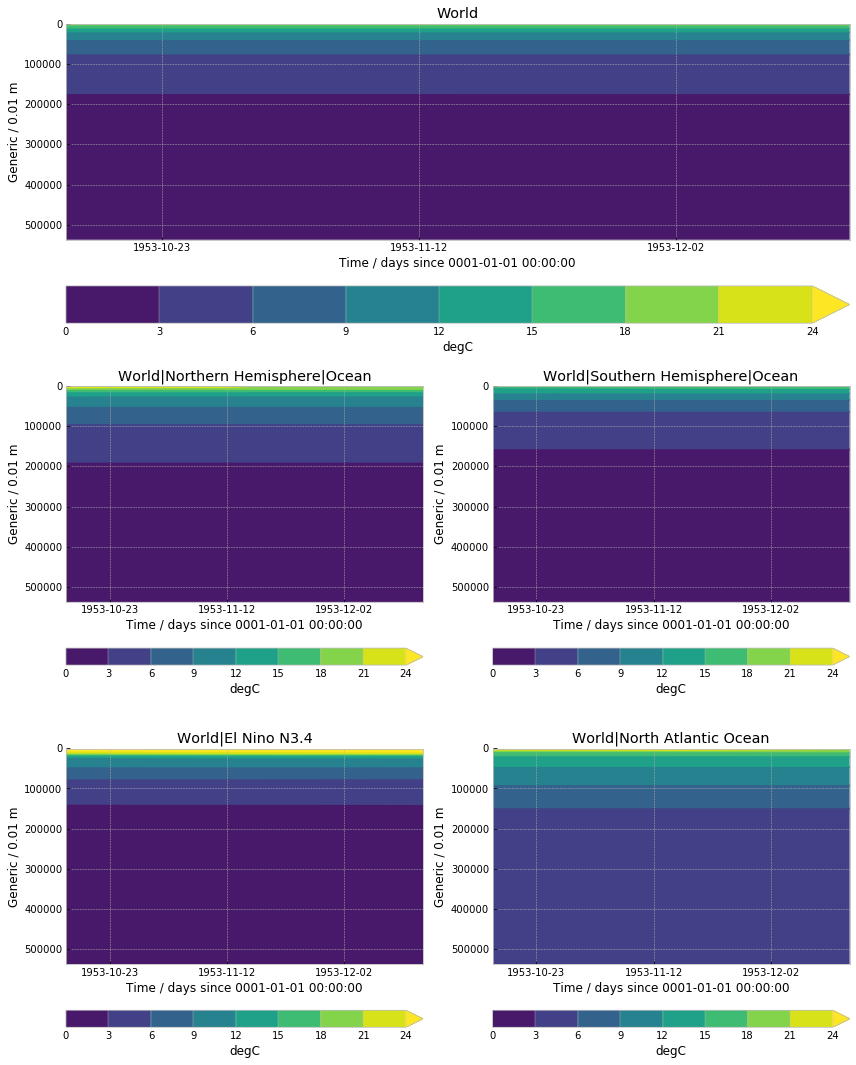

In [20]:
plt.figure(figsize=(12, 15))

plt.subplot(311)
qplt.contourf(
    thetao_ts_cubes["World"].cube, 
    extend='max',
    levels=range(0, 27, 3)
)
plt.title("World")

plt.subplot(323)
qplt.contourf(
    thetao_ts_cubes["World|Northern Hemisphere|Ocean"].cube, 
    extend='max',
    levels=range(0, 27, 3)
)
plt.title("World|Northern Hemisphere|Ocean")

plt.subplot(324)
qplt.contourf(
    thetao_ts_cubes["World|Southern Hemisphere|Ocean"].cube, 
    extend='max',
    levels=range(0, 27, 3)
)
plt.title("World|Southern Hemisphere|Ocean")

plt.subplot(325)
qplt.contourf(
    thetao_ts_cubes["World|El Nino N3.4"].cube, 
    extend='max',
    levels=range(0, 27, 3)
)
plt.title("World|El Nino N3.4")

plt.subplot(326)
qplt.contourf(
    thetao_ts_cubes["World|North Atlantic Ocean"].cube, 
    extend='max',
    levels=range(0, 27, 3)
)
plt.title("World|North Atlantic Ocean")

plt.tight_layout()

We have also not yet decided on our convention for handling the depth information in `SCMDataFrame`'s, hence attempting to retrieve SCM timeseries will result in an error.

In [21]:
# NBVAL_IGNORE_OUTPUT
try:
    thetao_cube.get_scm_timeseries(regions=regions_to_get)
except NotImplementedError as e:
    traceback.print_exc(limit=0, chain=False)

Not calculating land fractions as all required cubes are not available
Traceback (most recent call last):
NotImplementedError: Cannot yet get SCM timeseries for data with dimensions other than time, latitude and longitude
